In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
#import pandas_ta as ta # technical indicators
import datetime as dt
import xgboost as xgb

# Part 1 - Using in-class models
import sklearn.datasets as datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression #need this for linear regression
from sklearn.linear_model import LogisticRegression # need this for logistic regression
from sklearn.ensemble import RandomForestRegressor # need this for random forest regression
from sklearn.model_selection import train_test_split # need this for testing
from sklearn.metrics import mean_squared_error # need this for test evalution
from sklearn.svm import SVR # need this for SVR (regression)
from sklearn import linear_model
from sklearn.linear_model import Ridge

# Part 2 - GAPs as predictors
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import linregress

# Part 3 - Using LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# import to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#dataset_path = MachineLearningProject
df = pd.read_csv('/content/gdrive/MyDrive/MachineLearningProject/AMZN_Data.csv')
df.head()

#df = pd.read_csv('AMZN_data.csv')
#column_names = df.columns
#print(column_names)
#df.head()

Mounted at /content/gdrive


,Date,Close,RSI,CCI,ATR,EMA10,EMA50,EMA200
0,2015-11-12,33.279999,75.822797,107.514152,0.710155,32.422834,28.960422,23.307843
1,2015-11-13,32.117500,62.290222,33.838715,0.754251,32.367319,29.084229,23.395501
2,2015-11-16,32.390499,63.918821,-13.658603,0.799304,32.371533,29.213887,23.485003
3,2015-11-17,32.165001,61.554077,2.229270,0.785961,32.333982,29.329617,23.571371
4,2015-11-18,33.176998,67.385643,57.001979,0.806892,32.487258,29.480495,23.666950


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Assume df is loaded and sorted by date
# Extract features and target
feature_columns = df.columns[2:]  # x1 to xN
target_column = df.columns[1]     # y

# Scale both features and target
sc_features = StandardScaler()
sc_target = StandardScaler()


scaled_feature_values = sc_features.fit_transform(df[feature_columns])
scaled_target_values = sc_target.fit_transform(df[[target_column]])

# Store everything into a new DataFrame
scaled_df = pd.DataFrame(scaled_feature_values, columns=feature_columns)
scaled_df[target_column] = scaled_target_values.flatten()
scaled_df['Date'] = pd.to_datetime(df['Date'])  # Ensures consistent datetime format


In [5]:
lookback = 200
forecast_horizon = 10

X, y, future_dates = [], [], []

for i in range(lookback, len(scaled_df) - forecast_horizon):
    X_window = scaled_df.iloc[i - lookback:i, :-2].values  # all features except y and date
    target_column_index = scaled_df.columns.get_loc(target_column)
    y_target = scaled_df.iloc[i + forecast_horizon, target_column_index]
    date_of_prediction = scaled_df.iloc[i + forecast_horizon]['Date']

    X.append(X_window)
    y.append(y_target)
    future_dates.append(date_of_prediction)

X = np.array(X)  # shape: (samples, timesteps=90, features)
y = np.array(y)
future_dates = np.array(future_dates)


In [6]:
split_idx = int(len(X) * 0.75)

X_trainl, X_testl = X[:split_idx], X[split_idx:]
y_trainl, y_testl = y[:split_idx], y[split_idx:]
dates_train, dates_test = future_dates[:split_idx], future_dates[split_idx:]

In [8]:
!pip install keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import ReLU


def build_model(hp):
    model = Sequential()

    # Layer 1: LSTM
    model.add(LSTM(
        units=hp.Int('units1', 64, 128, step=32),
        return_sequences=True,
        input_shape=(X_trainl.shape[1], X_trainl.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.1)))

    # Layer 2: LSTM
    model.add(LSTM(
        units=hp.Int('units2', 32, 128, step=32),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.4, step=0.1)))

    # Layer 3: Bidirectional LSTM
    model.add(Bidirectional(LSTM(
        units=hp.Int('units3', 64, 128, step=32),
        return_sequences=False
    )))
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.4, step=0.1)))

    # Dense layers
    model.add(Dense(
        units=hp.Int('dense_units1', 64, 128, step=16),
        activation='relu'
    ))
    model.add(Dense(
        units=hp.Int('dense_units2', 64, 128, step=16),
        activation='relu'
    ))

    # Final output layer
    model.add(Dense(1))
    model.add(ReLU())  # Ensures non-negative output


    # Compile model
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-3, 1e-4, 1e-5])),
        loss='huber',
        metrics=['mae']
    )

    return model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=8,
    directory='lstm_tuning',
    project_name='stock_prediction',
    overwrite = True
)

tuner.search(X_trainl, y_trainl, validation_split=0.1, epochs=25, batch_size=16, callbacks=[early_stop])

best_model = tuner.get_best_models(num_models=1)[0]

best_model_count = 1
#best_model.save(f'best_model_{best_model_count}')
#best_model_count += 1

Trial 3 Complete [00h 08m 27s]
val_loss: 0.05293611343950033

Best val_loss So Far: 0.05239237518981099
Total elapsed time: 00h 22m 32s


In [10]:
# Retrieve the best hyperparameters from the search
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the values
print("Best hyperparameters found:")
print(f"Units Layer 1: {best_hp.get('units1')}")
print(f"Dropout Layer 1: {best_hp.get('dropout1')}")
print(f"Units Layer 2: {best_hp.get('units2')}")
print(f"Dropout Layer 2: {best_hp.get('dropout2')}")
print(f"Units Layer 3: {best_hp.get('units3')}")
print(f"Dropout Layer 3: {best_hp.get('dropout3')}")
print(f"Dense Units1: {best_hp.get('dense_units1')}")
print(f"Dense Units2: {best_hp.get('dense_units2')}")
print(f"Learning Rate: {best_hp.get('lr')}")


Best hyperparameters found:
Units Layer 1: 64
Dropout Layer 1: 0.2
Units Layer 2: 128
Dropout Layer 2: 0.2
Units Layer 3: 96
Dropout Layer 3: 0.30000000000000004
Dense Units1: 96
Dense Units2: 80
Learning Rate: 1e-05


In [11]:
# Use best_hp to rebuild the model
model_optimized = Sequential()
model_optimized.add(LSTM(units=best_hp.get('units1'), return_sequences=True, input_shape=(X_trainl.shape[1], X_trainl.shape[2])))
model_optimized.add(Dropout(best_hp.get('dropout1')))
model_optimized.add(LSTM(units=best_hp.get('units2'), return_sequences=True))
model_optimized.add(Dropout(best_hp.get('dropout2')))
model_optimized.add(LSTM(units=best_hp.get('units3'), return_sequences=False))
model_optimized.add(Dropout(best_hp.get('dropout3')))
model_optimized.add(Dense(units=best_hp.get('dense_units1'), activation='relu')) # Use dense_units1
model_optimized.add(Dense(units=best_hp.get('dense_units2'), activation='relu')) # Use dense_units2
model_optimized.add(Dense(1, activation = 'relu'))
model_optimized.compile(optimizer=Adam(learning_rate=best_hp.get('lr')), loss='mean_squared_error')

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

#y_pred = np.clip(y_pred, 0, 1)
y_pred = model_optimized.predict(X_testl).flatten()
"""
mse = mean_squared_error(y_testl, y_pred)
r2 = r2_score(y_testl, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
"""
# Inverse transform both predictions and test targets
y_pred_unscaled = sc_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_testl_unscaled = sc_target.inverse_transform(y_testl.reshape(-1, 1)).flatten()

# Now compute proper metrics
mse = mean_squared_error(y_testl_unscaled, y_pred_unscaled)
r2 = r2_score(y_testl_unscaled, y_pred_unscaled)
mae = np.mean(np.abs(y_testl_unscaled - y_pred_unscaled))
rmse = np.sqrt(mse)


print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f})")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error (MSE): 4358.4271
R² Score: -2.8049
Mean Absolute Error (MAE): 57.7130
Root Mean Squared Error (RMSE): 66.0184)


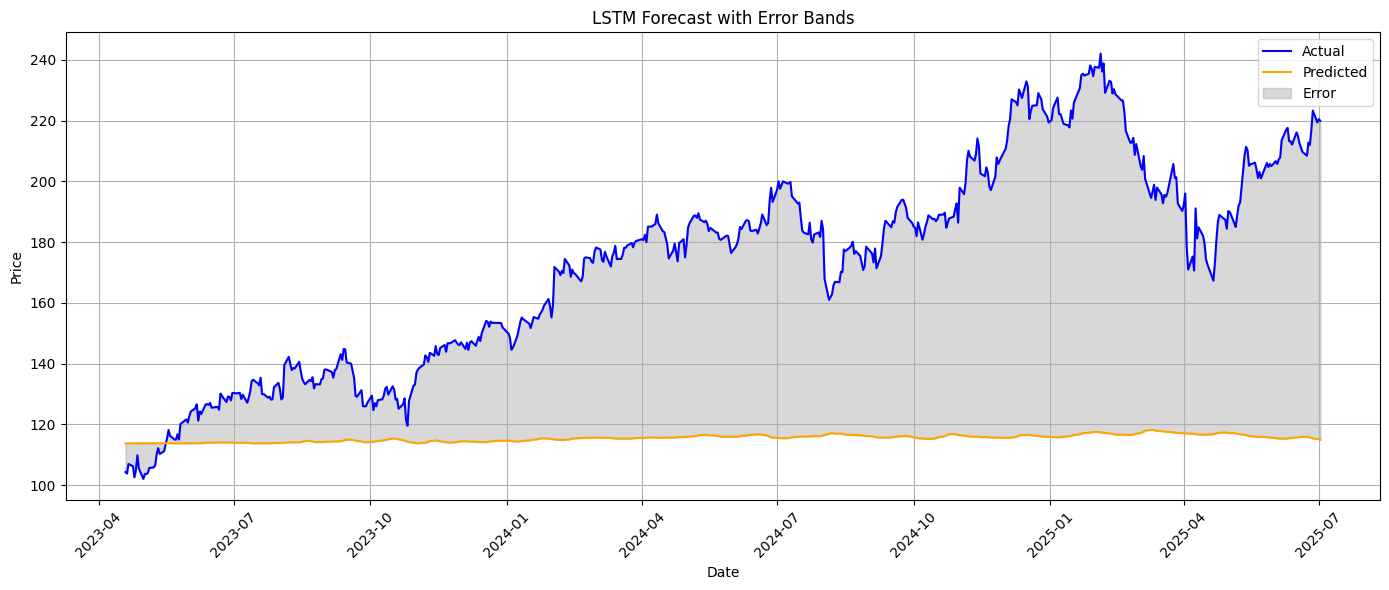

In [13]:
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_testl_unscaled, color='blue', label='Actual')
plt.plot(dates_test, y_pred_unscaled, color='orange', label='Predicted')
plt.fill_between(dates_test, y_pred_unscaled, y_testl_unscaled, color='gray', alpha=0.3, label='Error')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM Forecast with Error Bands')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
history = best_model.fit(
    X_trainl, y_trainl,
    validation_split=0.1,
    epochs=25,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

"""""
import yfinance as yf
import pandas as pd
import datetime

# Define date range
start_date = datetime.date(2015, 10, 21)
end_date = datetime.date(2025, 7, 2)

# Create date list (daily frequency)
date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' = business days

# Prepare storage
iv_data = []

# Loop through each date
for date in date_range:
    try:
        ticker = yf.Ticker("AMZN")
        expirations = ticker.options
        if not expirations:
            continue

        # Choose nearest expiration
        nearest_exp = expirations[0]
        chain = ticker.option_chain(nearest_exp)
        calls = chain.calls

        # Get average implied volatility from calls
        avg_iv = calls['impliedVolatility'].mean()
        iv_data.append({'Date': date.date(), 'ImpliedVolatility': avg_iv})
    except Exception as e:
        print(f"Error on {date.date()}: {e}")
        continue

# Save to CSV
df_iv = pd.DataFrame(iv_data)
df_iv.to_csv('AMZN_daily_implied_volatility.csv', index=False)
"""""